In [1]:

from DescritoresDeImagem.readwritendarray import extractimagesdescriptor, readfilendarray
from DescritoresDeImagem.utils import lpq_function

# Standart Scale, SVC and KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from scipy.stats import loguniform

import numpy as np
import pickle


In [2]:
#GLCM

distances=[1,2,4,8,16,32,64,128,256]
angles=np.deg2rad([0,45,90,180,270])


#LBP
Winsize=25

decorr=1

CVPARTS=5 # number of CV parts
RUN=False

if RUN:
    function_glcm=extractimagesdescriptor("DadosExtraidos/Y_Resultado.txt","DadosExtraidos/X_GLCM.txt","BasedeDados/*.bmp","GLCM",)
    function_glcm(angles=angles,distances=distances)

    function_lbp=extractimagesdescriptor(file="DadosExtraidos/Y_Resultado.txt",filename="DadosExtraidos/X_LBP.txt",pathimg="BasedeDados/*.bmp",descriptor="LBP")
    function_lbp(winSize=Winsize,decorr=decorr)



X_lbp=readfilendarray(filename="DadosExtraidos/X_LBP.txt")

X_lpq=lpq_function("BasedeDados/*.bmp",P=25,R=6)

X_glcm=readfilendarray(filename="DadosExtraidos/X_GLCM.txt")

y=readfilendarray(filename="DadosExtraidos/Y_Resultado.txt",data="s")

y = y.reshape(-1, 1)

x_lpq_lpq_glcm=np.concatenate((X_lbp,X_lpq,X_glcm,y),axis=1)


knn_x_lpq_lpq_glcm=np.concatenate((X_lbp,X_lpq,y),axis=1)

X_train_model,X_test_model=train_test_split(x_lpq_lpq_glcm,test_size=0.2,train_size=0.8,random_state=999)

X_train_knn_model,X_test_knn_model=train_test_split(knn_x_lpq_lpq_glcm,test_size=0.2,train_size=0.8,random_state=999)
print(X_train_knn_model.shape)

(3360, 860)


In [ ]:
y_train=X_train_model[:,-1]
y_test=X_test_model[:,-1]


X_train_model=X_train_model[:,:-1]
X_test_model=X_test_model[:,:-1]



In [3]:
y_test_knn=X_test_knn_model[:,-1]
y_train_knn=X_train_knn_model[:,-1]

X_test_knn_model=X_test_knn_model[:,:-1]
X_train_knn_model=X_train_knn_model[:,:-1]


In [4]:
def randomgridsearchotimizator(n_iter:int,scoring:str,cvparts,pipe,parameters):
    return RandomizedSearchCV(estimator=pipe,param_distributions=parameters,n_iter=n_iter,scoring=scoring,cv=cvparts,n_jobs=6,error_score='raise')

In [ ]:
pipe=Pipeline(steps=[("scalar",StandardScaler()),
                     ('pca', PCA()),
                     ("model",SVC())])


parameters = {
    "pca__n_components":[16,32,64,128,256,280,300,1024,2048],
    "pca__svd_solver":['auto', 'full', 'arpack', 'randomized'],
    "model__coef0": [0,1,2,3,4,5,10,15,20],
    "model__degree": [1,2,3,4,5,10,15,18,20],
    "model__kernel": ['poly',"rbf","sigmoid"],
    "model__C": loguniform(1e-5, 1e3),
    "model__gamma": ["scale", "auto"],
    "model__tol": loguniform(1e-5, 1e-1),
}



In [ ]:

NOTOPTPARAMATERS=True
svmlbp_lpq=None

if NOTOPTPARAMATERS:
    with open("./Models/svm_LBP_LPQ_GLCM.pkl",mode="rb") as f:
        svmlbp_lpq=pickle.load(f)
else:
    svmlbp_lpq=randomgridsearchotimizator(parameters=parameters,pipe=pipe,scoring="f1_macro",cvparts=5,n_iter=30)

In [ ]:
if not NOTOPTPARAMATERS:
    svmlbp_lpq.fit(X=X_train_model,y=y_train)

KeyboardInterrupt: 

In [ ]:
print(svmlbp_lpq.best_score_)
print(svmlbp_lpq.best_params_)


0.7664628965097929
{'model__C': np.float64(0.1554544978843174), 'model__coef0': 10, 'model__degree': 10, 'model__gamma': 'scale', 'model__kernel': 'poly', 'model__tol': np.float64(0.0002537045643644857), 'pca__n_components': 1024, 'pca__svd_solver': 'arpack'}


In [ ]:
ln=LabelEncoder()
ln_y_teste_svm=ln.fit_transform(y_test)

In [ ]:
ypredsvmglcm=svmlbp_lpq.predict(X=X_test_model)

In [ ]:
print("\tSVM (LBP+LPQ+GLCM) \n")
print(classification_report(ln_y_teste_svm,y_pred=ypredsvmglcm)+"\n")

	SVM (LBP+LPQ+GLCM) 

              precision    recall  f1-score   support

           0       0.80      0.81      0.80        73
           1       0.88      0.86      0.87        66
           2       0.68      0.80      0.73        64
           3       0.77      0.76      0.77        76
           4       0.72      0.68      0.70        74
           5       0.77      0.70      0.73        76
           6       0.78      0.80      0.79        66
           7       0.85      0.74      0.79        72
           8       0.86      0.75      0.80        72
           9       0.84      0.85      0.85        87
          10       0.66      0.73      0.69        51
          11       0.66      0.79      0.72        63

    accuracy                           0.77       840
   macro avg       0.77      0.77      0.77       840
weighted avg       0.78      0.77      0.77       840




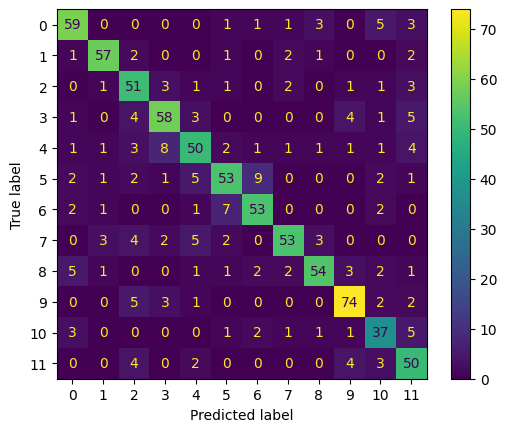

In [ ]:
ConfusionMatrixDisplay.from_predictions(ln_y_teste_svm,y_pred=ypredsvmglcm)

In [ ]:
pipe_knn=Pipeline(steps=[("scalar",StandardScaler()),
                     ('pca', PCA()),
                     ("knn",KNeighborsClassifier())]) 
parameters_knn = {
    "pca__n_components":[16,20,32,35,36,40,41,42,43,64,128],
    "pca__svd_solver":['auto', 'full', 'randomized'],
    "knn__n_neighbors": [1,2,3,5,7,10,15,20,25,30],  
    "knn__weights": ['uniform', 'distance'],
    "knn__metric": ['euclidean', 'manhattan','chebyshev'], 
    "knn__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "knn__leaf_size": [1,2,3,4,5,10,20, 30,50],  
    "knn__p": [1, 2]  
}



In [12]:

NOTOPTPARAMATERS=False

if NOTOPTPARAMATERS:
   knn_lbp_lqb_glcm=svmlbp_lpq=pickle.load("./Models/knn_LBP_LPQ_GLCM.pkl")
else:
    knn_lbp_lqb_glcm=randomgridsearchotimizator(parameters=parameters_knn,pipe=pipe_knn,scoring="f1_macro",cvparts=CVPARTS,n_iter=29)

In [13]:
labelencoder=LabelEncoder()

ln_y=labelencoder.fit_transform(y_train_knn)

In [14]:
knn_lbp_lqb_glcm.fit(X=X_train_knn_model,y=ln_y)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                             ('pca', PCA()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=29, n_jobs=6,
                   param_distributions={'knn__algorithm': ['auto', 'ball_tree',
                                                           'kd_tree', 'brute'],
                                        'knn__leaf_size': [1, 2, 3, 4, 5, 10,
                                                           20, 30, 50, 60, 70,
                                                           80, 85, 89, 90, 100,
                                                           1000],
                                        'knn__metric': ['euclidean',
                                                        'manhattan',
                                                        'chebyshev'],
                                        'knn__n_neighbors': [1, 2, 3, 5, 7, 10,
                                                             15, 20, 25, 30, 50,
                                                             100, 500, 1000],
                                        'knn__p': [1, 2],
                                        'knn__weights': ['uniform', 'distance'],
                                        'pca__n_components': [16, 20, 32, 35,
                                                              36, 40, 42, 43,
                                                              64, 128],
                                        'pca__svd_solver': ['auto', 'full',
                                                            'arpack',
                                                            'randomized']},
                   scoring='f1_macro')

In [18]:

ln_y_test=labelencoder.fit_transform(y_test_knn)

print(knn_lbp_lqb_glcm.best_params_)
print(knn_lbp_lqb_glcm.best_score_)

{'pca__svd_solver': 'full', 'pca__n_components': 40, 'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 15, 'knn__metric': 'euclidean', 'knn__leaf_size': 1, 'knn__algorithm': 'brute'}
0.5202237044550975


In [19]:
ypredknnglcm=knn_lbp_lqb_glcm.predict(X=X_test_knn_model)

In [20]:
print("\tKNN(LBP+LPQ+GLCM) \n")
print(classification_report(y_true=ln_y_test,y_pred=ypredknnglcm)+"\n")

	KNN(LBP+LPQ+GLCM) 

              precision    recall  f1-score   support

           0       0.84      0.36      0.50        73
           1       0.68      0.62      0.65        66
           2       0.24      0.59      0.35        64
           3       0.57      0.45      0.50        76
           4       0.44      0.38      0.41        74
           5       0.41      0.29      0.34        76
           6       0.57      0.48      0.52        66
           7       0.83      0.54      0.66        72
           8       0.91      0.43      0.58        72
           9       0.60      0.64      0.62        87
          10       0.38      0.69      0.49        51
          11       0.41      0.60      0.49        63

    accuracy                           0.50       840
   macro avg       0.57      0.51      0.51       840
weighted avg       0.58      0.50      0.51       840




In [ ]:
with open(f"Models/svm_LBP_LPQ_GLCM.pkl",mode="wb") as fsvm:
    pickle.dump(svmlbp_lpq,fsvm)


In [21]:

with open("Models/knn_LBP_LPQ_GLCM.pkl",mode="wb") as fknn:
    pickle.dump(knn_lbp_lqb_glcm,fknn)